# Analisi RLC serie

In [15]:
import numpy as np
from scipy import fft, optimize, linalg, stats, interpolate
from scipy.constants import pi
from matplotlib import pyplot as plt
from lmfit import Model, Parameters, minimize, fit_report
import pandas as pd
import matplotlib
from uncertainties import ufloat

%matplotlib inline

In [16]:
C = 32.02*10**-9     #F
L = 10.17 * 10**-3   #H
R_res = 35.308       #Ohm
R_L = 41.407
R_gen = 50
R = R_res + R_L + R_gen
V0 = 5               #Volt
pulse_width = 1 * 10**-6

C_err = 0.01 * C
L_err = 0.01 * L

omega0_exp = 1/np.sqrt(L*C)
gamma_exp = R / L
R_res_err = (450 * R_res + 310 * 100) * 10**-6
R_L_err = (450 * R_L + 310 * 100) * 10**-6

uC = ufloat(C, C_err)
uR_res = ufloat(R_res, R_res_err)
uR_L = ufloat(R_L, R_L_err)
uL = ufloat(L, L_err)

uR = uR_res + uR_L + R_gen
uOmega0 = (uC*uL)**(-0.5)
uGamma = uR / uL

omega0_exp_err = uOmega0.std_dev
gamma_exp_err = uGamma.std_dev
R_err = uR.std_dev

print('R_res ', uR_res)
print('C ', uC)
print('L ', uL)
print('R_L ', uR_L)
print('omega0_exp ', uOmega0)
print('gamma_exp ', uGamma)
print('nu0', uOmega0/2/pi)
print('nur', (uOmega0**2 - uGamma**2 / 4)**0.5 / (2*pi))

R_res  35.31+/-0.05
C  (3.202+/-0.032)e-08
L  0.01017+/-0.00010
R_L  41.41+/-0.05
omega0_exp  (5.54+/-0.04)e+04
gamma_exp  (1.246+/-0.012)e+04
nu0 (8.82+/-0.06)e+03
nur (8.76+/-0.06)e+03


In [17]:
def f(t, amp, gamma, omega0, t0):
    return amp * np.exp(-gamma*(t+t0)/(2)) * np.sin(np.sqrt(omega0**2 - gamma**2 / 4) * (t+t0))
    #return amp * np.exp(-gamma*(t+t0)/(2)) * np.sin(np.sqrt(omega0**2) * (t+t0))

def H(f, omega0, gamma, amp, t0):
    return  (amp *V0 * pulse_width/ (1 - (2*pi*f / omega0)**2 + 1j * (gamma/omega0**2) * (2*pi*f)))*np.exp(1j * t0 * 2*pi*f)

def phase_err(x,y, dx, dy):
    return 1 / (1+y**2/x**2) * np.sqrt(y**2/x**4 * dx**2 + dy**2 / x**2)
def amp_err(x,y,dx,dy):
    return np.sqrt((x**2 * dx**2 + y**2 * dy**2)/(x**2 + y**2))

H_Model = Model(H)
f_Model = Model(f)

def H_residuals(pars, freqs, data, err):
    model = H_Model.eval(f=freqs, params=pars)
    return (data - model).view(float) / np.sqrt(2) / (err).view(float)

def R2(x, y, z):
    mean = np.mean(y)
    r2 = 1- np.sum(np.abs(z-y)**2) / np.sum(np.abs(y-mean)**2)
    return r2

In [18]:
data_path = 'C:/Users/nicmo/OneDrive - Alma Mater Studiorum Università di Bologna/Università/2. T Secondo Anno/LEO/Esperimento/data/'

pulse_name = 'Pulse_3.14-oscilloscope.csv'
trans_name = 'Trans_3-oscilloscope.csv'
fft_name = 'Pulse_1-FFT.csv'
freqs_name = 'Freqs_2.10.1-freqs.csv'

In [19]:
data_pulse_info = pd.read_csv(data_path + pulse_name, delimiter=',', header=0, nrows=2, index_col=0)
dataframe = pd.read_csv(data_path + pulse_name, delimiter=',', header=3)

V = np.array(dataframe['V_C'])
Vs = np.array(dataframe['V_S'])
V = V - (np.sum(V[-11:-1]))/10

V_err = ((130+13*1+1*10)*V + (80+55+60)*0.2 + 16*3/1)*10**-6
#V_err = 32*1/1 * 10**-6 * np.ones(V.size)
#V_err = 1045*10**-6*np.ones(V.size)

dt = float(data_pulse_info['V_S']['delta t'])
t = np.linspace(0, V.size, V.size) * dt

In [40]:
pars_exp = f_Model.make_params(amp=1, omega0 = omega0_exp, t0=0, gamma=gamma_exp)

V_err = np.ones(V.size)*np.std(V[600:])
result_time = f_Model.fit(V, t=t, params=pars_exp, weights=1/V_err, scale_covar=False)
pars_time = result_time.params
print(result_time.fit_report())
#V_err = np.sqrt(result_time.redchi) * np.ones(V.size)
#V_err = result_time.eval_uncertainty()
print(V_err[10])

r2 = R2(t, V, (f_Model.eval(pars_time, t=t,)))
print('\nR2 = ', r2)

[[Model]]
    Model(f)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 31
    # data points      = 800
    # variables        = 4
    chi-square         = 1138.23387
    reduced chi-square = 1.42994205
    Akaike info crit   = 290.097101
    Bayesian info crit = 308.835547
[[Variables]]
    amp:     0.14347151 +/- 8.5449e-06 (0.01%) (init = 1)
    gamma:   13501.7261 +/- 1.13669417 (0.01%) (init = 12459.69)
    omega0:  56983.1683 +/- 0.55883462 (0.00%) (init = 55415.19)
    t0:      1.7992e-06 +/- 1.0384e-09 (0.06%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(amp, gamma)    =  0.726
    C(omega0, t0)    = -0.715
    C(gamma, omega0) =  0.233
    C(amp, omega0)   =  0.167
    C(gamma, t0)     = -0.166
    C(amp, t0)       = -0.119
2.5080366175215208e-05

R2 =  0.9999980825889969


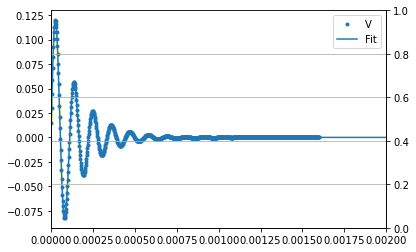

In [41]:
t_cont = np.linspace(0,0.002,1000)

fig_t = plt.figure()
ax_t = fig_t.add_subplot()
ax_s = ax_t.twinx()
ax_t.plot(t, V, marker='.', label='V', linestyle='', color='tab:blue')
#ax_s.plot(t, Vs, marker='', label='Vs', color='red')
ax_t.plot(t_cont, f_Model.eval(t=t_cont, params=result_time.params), label='Fit', color='tab:blue', marker='')
ax_t.fill_between(t, V-V_err, V+V_err, color='yellow', alpha=0.5)


imax_t = np.argmin(np.abs(t-0.004))

#ax_t.set_ylim(-0.025, 0.025)
#ax_s.set_ylim(-2.5,2.5)
ax_t.set_xlim(0,0.002)
plt.grid()
ax_t.legend()

In [42]:
df_result_time = pd.DataFrame(np.array([t*1000, V, Vs]).T, columns=['time', 'Vc', 'Vs'])
df_result_time_fit = pd.DataFrame(np.array([t_cont*1000, f_Model.eval(t=t_cont, params=result_time.params)]).T, columns=['time', 'Vc_fit'])
df_result_time.to_csv('time_results.csv', index=False, sep=',')
df_result_time_fit.to_csv('time_fit_results.csv', index=False, sep=',')

In [43]:
V_fft = fft.fft(V) * dt
freqs_fft = fft.fftfreq(V_fft.size, dt)

def adjust_angle(a):
    return (a - 2 * pi * (a > 0.5) - 2*pi*(a>3.2))

V_fft_amp = np.abs(V_fft)
V_fft_phase = adjust_angle(np.angle(V_fft))

A_fft = linalg.dft(V_fft.size)*dt
A_err_r = np.real(A_fft)
V_fft_err_r = np.sqrt(np.dot(np.absolute(A_err_r)**2,np.absolute(V_err)**2))
#V_fft_err_r = (np.dot(np.absolute(A_err_r),np.absolute(V_err)))
A_err_i = np.imag(A_fft)
V_fft_err_i = np.sqrt(np.dot(np.absolute(A_err_i)**2,np.absolute(V_err)**2))
#V_fft_err_i = (np.dot(np.absolute(A_err_i),np.absolute(V_err)))
V_fft_err = V_fft_err_r + 1j*V_fft_err_i

In [44]:
imin_fft = np.argmin(np.abs(freqs_fft - 1000))
imax_fft = np.argmin(np.abs(freqs_fft - 300000))
freqs_fft_fit = freqs_fft[imin_fft:imax_fft]

pars_exp['amp'].value = 1
pars_exp['t0'].vary = True

#result_fft = H_Model.fit(V_fft[imin_fft:imax_fft], f=freqs_fft_fit, params=pars_exp, scale_covar=True)
#pars_fft = result_fft.params
#print('FFT', '\n', result_fft.fit_report())

pars_exp['amp'].vary = True
pars_time['t0'].vary = True
result_fft = minimize(H_residuals, pars_time, scale_covar=True, args=(freqs_fft_fit, V_fft[imin_fft:imax_fft], V_fft_err[imin_fft:imax_fft]), xtol=10**-15, ftol=10**-15)
pars_fft = result_fft.params
print('FFT ERRS', '\n', fit_report(result_fft))

pars_exp['t0'].vary = False
pars_exp['amp'].vary = True

result_fft_fixed = H_Model.fit(V_fft[imin_fft:imax_fft], f=freqs_fft_fit, params=pars_exp)
pars_fft_fixed = result_fft_fixed.params
print('\n', 'FREQS', '\n', result_fft_fixed.fit_report())

omega0_fft = pars_fft['omega0'].value
gamma_fft = pars_fft['gamma'].value
omega0_fft_err = pars_fft['omega0'].stderr
gamma_fft_err = pars_fft['gamma'].stderr
t0_fft = pars_fft['t0'].value
t0_fft_err = pars_fft['t0'].stderr

omega0_time = pars_time['omega0'].value
gamma_time = pars_time['gamma'].value
omega0_time_err = pars_time['omega0'].stderr
gamma_time_err = pars_time['gamma'].stderr
t0_time = pars_time['t0'].value
t0_time_err = pars_time['t0'].stderr

uOmega0_fft = ufloat(omega0_fft, omega0_fft_err)
uOmega0_time = ufloat(omega0_time, omega0_time_err)
ut0_fft = ufloat(t0_fft, t0_fft_err)
ut0_time = ufloat(t0_time, t0_time_err)
uGamma_fft = ufloat(gamma_fft, gamma_fft_err)
uGamma_time = ufloat(gamma_time, gamma_time_err)

FFT ERRS 
 [[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 30
    # data points      = 794
    # variables        = 4
    chi-square         = 1194.09515
    reduced chi-square = 1.51151285
    Akaike info crit   = 332.000051
    Bayesian info crit = 350.708385
[[Variables]]
    amp:     0.49945439 +/- 5.1070e-05 (0.01%) (init = 0.1434715)
    gamma:   13520.4635 +/- 1.99332302 (0.01%) (init = 13501.73)
    omega0:  57054.9272 +/- 0.96502100 (0.00%) (init = 56983.17)
    t0:      1.7957e-06 +/- 1.7737e-09 (0.10%) (init = 1.799214e-06)
[[Correlations]] (unreported correlations are < 0.100)
    C(omega0, t0)    = -0.709
    C(amp, gamma)    =  0.694
    C(gamma, omega0) =  0.229
    C(gamma, t0)     = -0.163

 FREQS 
 [[Model]]
    Model(H)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 25
    # data points      = 794
    # variables        = 3
    chi-square         = 3.1405e-12
    reduced chi-square = 3.9703e-15
    Akaike inf

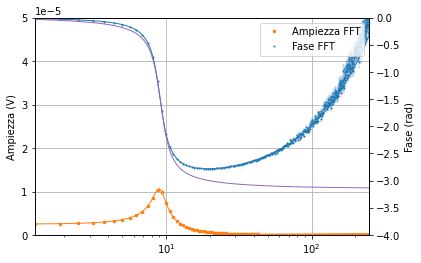

In [45]:
f_cont = np.linspace(1000, 250000, 4000)
V_fft_fit_amp = np.abs(H_Model.eval(pars_fft, f=f_cont))
V_fft_fit_phase = np.angle(H_Model.eval(pars_fft, f=f_cont))
V_fft_fit_fixed_amp = np.abs(H_Model.eval(pars_fft_fixed, f=f_cont))
V_fft_fit_fixed_phase = np.angle(H_Model.eval(pars_fft_fixed, f=f_cont))
V_fft_phase_err = phase_err(np.real(V_fft), np.imag(V_fft), np.real(V_fft_err), np.imag(V_fft_err))
V_fft_amp_err = amp_err(np.real(V_fft), np.imag(V_fft), np.real(V_fft_err), np.imag(V_fft_err))
V_fft_fit_phase_err = interpolate.interp1d(freqs_fft, V_fft_phase_err, bounds_error=False, fill_value=V_fft_phase_err[-1])(f_cont)

#fig_fft, (ax_fft_amp, ax_freqs_amp) = plt.subplots(2,1)
fig_freqs = plt.figure('Frequency domain')
ax_fft_amp = fig_freqs.add_subplot()

ax_fft_phase = ax_fft_amp.twinx()
#ax_freqs_phase = ax_freqs_amp.twinx()

ax_fft_amp.plot(freqs_fft/1000, V_fft_amp, marker='.', markersize=5, linestyle='', color='tab:orange', label='Ampiezza FFT')
ax_fft_phase.plot(freqs_fft/1000, V_fft_phase, marker='.', linestyle='', markersize=2, color='tab:blue', label='Fase FFT')

ax_fft_amp.plot(f_cont/1000, V_fft_fit_amp,linewidth=1, color='tab:orange')
ax_fft_phase.plot(f_cont/1000, V_fft_fit_phase,linewidth=1, color='tab:blue')

ax_fft_amp.errorbar(freqs_fft/1000, V_fft_amp, yerr=V_fft_amp_err, color='tab:orange', linestyle='')
ax_fft_phase.errorbar(freqs_fft/1000, V_fft_phase, yerr=np.abs(V_fft_phase_err), color='tab:blue', linestyle='', alpha=0.2)


#ax_freqs_amp.plot(freqs/1000, np.abs(V_freqs), marker='.', linestyle='', markersize=3, color='tab:red', label='Ampiezza sweep')
#ax_freqs_phase.plot(freqs/1000, adjust_angle(np.angle(V_freqs)), marker='.', linestyle='', markersize=3, color='tab:purple', label='Fase sweep')

#ax_freqs_amp.plot(f_cont/1000, np.abs(H_Model.eval(pars_freqs, f=f_cont)),linewidth=1, color='tab:red')
ax_fft_phase.plot(f_cont/1000, np.angle(H_Model.eval(pars_fft_fixed, f=f_cont)), linewidth=1, color='tab:purple')

ax_fft_amp.set_xscale('log')
#ax_freqs_amp.set_xscale('log')
ax_fft_amp.set_xlim(freqs_fft[imin_fft]/1000, freqs_fft[imax_fft]/1000)
ax_fft_amp.set_ylim(0, 5*10**-5)
ax_fft_phase.set_ylim(-4,0)
#ax_freqs_phase.set_ylim(-pi,0)
ax_fft_amp.grid(True)
#ax_freqs_amp.grid(True)

#ax_freqs_amp.set_xlabel('Frequenza (Hz)')
#ax_freqs_amp.set_ylabel('Ampiezza (V)')
#ax_freqs_phase.set_ylabel('Fase (rad)')
ax_fft_amp.set_ylabel('Ampiezza (V)')
ax_fft_phase.set_ylabel('Fase (rad)')
fig_freqs.legend(bbox_to_anchor=(0.9,0.88))

<IPython.core.display.Javascript object>


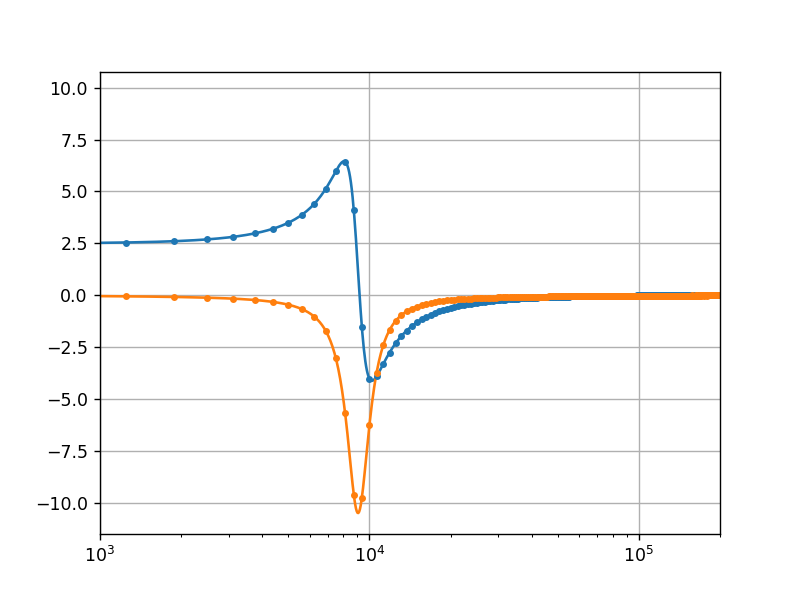

In [33]:
V_fft_r = np.real(V_fft) * 10**6
V_fft_i = np.imag(V_fft) * 10**6
V_fft_fit_r = np.real(H_Model.eval(f=f_cont, params=pars_fft))* 10**6
V_fft_fit_i = np.imag(H_Model.eval(f=f_cont, params=pars_fft))* 10**6
V_fft_err_r = np.real(V_fft_err) * 10**6
V_fft_err_i = np.imag(V_fft_err) * 10**6

fig = plt.figure()
ax = fig.add_subplot()
#ax.plot(freqs_fft, V_fft_r, linestyle='', marker='.', color='tab:blue')
#ax.plot(freqs_fft, V_fft_i, linestyle='', marker='.', color='tab:orange')
ax.plot(f_cont, V_fft_fit_r, color='tab:blue')
ax.plot(f_cont, V_fft_fit_i, color='tab:orange')
ax.errorbar(freqs_fft, V_fft_r, yerr=V_fft_err_r, color='tab:blue', linestyle='', marker='.')
ax.errorbar(freqs_fft, V_fft_i, yerr=V_fft_err_i, color='tab:orange', linestyle='', marker='.')
ax.set_xlim(1000, 200000)
ax.set_xscale('log')
ax.grid(True)

In [24]:
df_results = pd.DataFrame(np.array([freqs_fft/1000, V_fft_amp/10**-6, V_fft_phase, V_fft_amp_err/10**-6, V_fft_phase_err, V_fft_r, V_fft_i]).T, columns=['freqs', 'amp', 'phase', 'amp_err', 'phase_err', 'real', 'imag'])
df_fit = pd.DataFrame(np.array([f_cont/1000, V_fft_fit_amp/10**-6, V_fft_fit_phase, V_fft_fit_phase_err, V_fft_fit_r, V_fft_fit_i]).T, columns=['fit_freqs', 'fit_amp', 'fit_phase', 'fit_phase_err', 'fit_real', 'fit_imag'])
df_fit_fixed = pd.DataFrame(np.array([f_cont/1000, V_fft_fit_fixed_amp/10**-6, V_fft_fit_fixed_phase]).T, columns=['fit_freqs', 'fit_amp', 'fit_phase'])
df_results_err = pd.DataFrame(np.array([freqs_fft/1000, V_fft_amp_err/10**-6, V_fft_phase_err]).T, columns=['freqs', 'amp_err', 'phase_err'])
df_results.to_csv('fft_results.csv', index=False, sep=',')
df_fit.to_csv('fft_fit_results.csv', index=False, sep=',')
df_fit_fixed.to_csv('fft_fit_fixed_results.csv', index=False, sep=',')
df_results_err.to_csv('fft_results_err.csv', index=False, sep=',')

In [25]:
pars_fft.pretty_print()

omega_mes = pars_fft['omega0'].value
gamma_mes = pars_fft['gamma'].value
omega_mes_err = pars_fft['omega0'].stderr
gamma_mes_err = pars_fft['gamma'].stderr

r2 = R2(freqs_fft_fit, V_fft, (H_Model.eval(pars_fft, f=freqs_fft,)))
print('\nR2 = ', r2)

Name       Value      Min      Max   Stderr     Vary     Expr Brute_Step
amp       0.4995     -inf      inf 5.107e-05     True     None     None
gamma   1.352e+04     -inf      inf    1.993     True     None     None
omega0  5.705e+04     -inf      inf    0.965     True     None     None
t0      1.796e-06     -inf      inf 1.774e-09     True     None     None

R2 =  0.9999954211806295


In [26]:
fig_freqs.savefig('freqs.pdf')

In [27]:
print('Omega_exp:', omega0_exp, '+/-', omega0_exp_err)
print('Omega_fft:', omega0_fft, '+/-', omega0_fft_err)
print('Omega_time:', omega0_time, '+/-', omega0_time_err)
print('Sigmas fft-exp:', (omega0_fft - omega0_exp) / np.sqrt(omega0_fft_err**2 + omega0_exp_err**2))
print('Sigmas time-fft:', (omega0_fft - omega0_time) / np.sqrt(omega0_fft_err**2 + omega0_time_err**2))

print('\n')
print('gamma_exp:', gamma_exp, '+/-', gamma_exp_err)
print('gamma_fit:', gamma_fft, '+/-', gamma_fft_err)
print('gamma_time:', gamma_time, '+/-', gamma_time_err)
print('Sigmas:', (gamma_exp - gamma_fft) / np.sqrt(gamma_fft_err**2 + gamma_exp_err**2))
print('\n')
print('R^2: ', r2)

omega_r_exp = np.sqrt(omega0_exp**2-gamma_exp**2/2)
omega_r_exp_err = 1/(2*omega_r_exp)*np.sqrt(4*omega0_exp**2 * omega0_exp_err**2 + gamma_exp**2 * gamma_exp_err**2)

print('Omgea_r_exp: ', omega_r_exp, '\pm', omega_r_exp_err)
print('Nu_r_exp: ', omega_r_exp/(2*pi), '\pm', omega_r_exp_err/(2*pi))

Omega_exp: 55415.19422659059 +/- 391.84459618391816
Omega_fft: 57054.92723680439 +/- 0.9650210563358442
Omega_time: 56983.16830271815 +/- 0.6682554785894281
Sigmas fft-exp: 4.184638638742681
Sigmas time-fft: 61.133322462901965


gamma_exp: 12459.68534906588 +/- 124.7776031557382
gamma_fit: 13520.46347590674 +/- 1.9933230196175493
gamma_time: 13501.726142022731 +/- 1.3592609780585638
Sigmas: -8.500265834472964


R^2:  0.9999954211806295
Omgea_r_exp:  54710.34519788643 \pm 397.1470835657743
Nu_r_exp:  8707.421876507564 \pm 63.20792148402302


In [124]:
variables_file = open('variables.txt', 'wt')
variables_file.write('\\newcommand\varomega0_fft{' + str(uOmega0_fft/1000) + '}\n')
variables_file.write('\\newcommand\varomega0_time{' + str(uOmega0_time/1000) + '}\n')
variables_file.write('\\newcommand\varomega0_exp{' + str(uOmega0/1000) + '}\n')
variables_file.write('\\newcommand\vargamma_fft{' + str(uGamma_fft/1000) + '}\n')
variables_file.write('\\newcommand\vargamma_time{' + str(uGamma_time/1000) + '}\n')
variables_file.write('\\newcommand\vargamma_exp{' + str(uGamma/1000) + '}\n')
variables_file.write('\\newcommand\\vart0_fft{' + str(ut0_fft*10**6) + '}\n')
variables_file.write('\\newcommand\\vart0_time{' + str(ut0_time*10**6) + '}\n')
variables_file.write('\\newcommand\varR_res{' + str(uR_res) + '}\n')
variables_file.write('\\newcommand\varR_L{' + str(uR_L) + '}\n')
variables_file.write('\\newcommand\C{' + str(uC*10**9) + '}\n')
variables_file.write('\\newcommand\L{' + str(uL*1000) + '}\n')
variables_file.close()

print(uOmega0_time)
print(uGamma_time)
print(ut0_time)
print(uOmega0_fft)
print(uGamma_fft)
print(ut0_fft)

56983.2+/-0.7
13501.7+/-1.4
(1.7992+/-0.0012)e-06
57054.9+/-1.0
13520.5+/-2.0
(1.7957+/-0.0018)e-06
